# Funciones Usadas en el Trabajo

In [55]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

## Interpolación de Lagrange

In [56]:
"""
x: Lista de los nodos de la interpolación
y: Lista de los valores de la interpolación

return:
    itr: El polinomio de interpolación
    L: Lista que contiene los polinomios base
"""
def lagrange(x, y):
    n = len(x)
    # Calculamos los polinomios base
    L = []
    itr = Polynomial(0)
    for i in range(n):
        base = Polynomial([1])
        for j in range(n):
            if j != i:
                factor = Polynomial([-x[j], 1])/(x[i]-x[j])
                base = base * factor
        L.append(base)
        itr += y[i] * base
    return itr, L

## Interpolación de Newton

In [57]:
"""
x: Lista de los nodos de la interpolación
y: Lista de los valores de la interpolación

return:
    itr: El polinomio de interpolación
    N: Matriz que representa la tabla de diferencias divididas
"""
def newton(x, y):
    n = len(x)
    N = np.zeros((n, n))
    # Completamos la tabla de diferencias divididas
    N[0,:] = y
    for i in range(1,n):
        for j in range(n-i):
            top = N[i-1,j] - N[i-1,j+1]
            bottom = x[j] - x[j+i]
            N[i,j] = top/bottom
    # Calculamos los polinomios base
    itr = Polynomial(0)
    for i in range(n):
        base = Polynomial([1])
        for j in range(i):
            factor = Polynomial([-x[j], 1])
            base = base * factor
        itr += N[i,0] * base
        
    return itr, N

## Interpolación de Hermite

In [58]:
"""
X: Lista de los nodos de la interpolación
Y: Lista de los valores de la interpolación
DY: Lista de las derivadas de la interpolación

return:
  itr: El polinomio de interpolación
  H, DH: Listas que contienen los polinomios base
"""
def hermite(X, Y, DY):
    n = len(X)
    _, L = lagrange(X, Y)
    DL = [p.deriv() for p in L]
    H = []
    S1 = Polynomial(0)
    for i in range(n):
        r = (Polynomial(1)-2*Polynomial([-X[i],1])*DL[i](X[i]))*L[i]**2
        S1 += Y[i]*r
        H.append(r)

    DH = []
    S2 = Polynomial(0)
    for i in range(n):
        r = Polynomial([-X[i],1])*L[i]**2
        S2 += DY[i]*r
        DH.append(r)
    itr = S1 + S2
    return itr, H, DH

## Interpolación de splines

### Spline Lineal

In [59]:
"""
X: Lista de los nodos de la interpolación
Y: Lista de los valores de la interpolación
return:
  CS: Lista de los trazadores (polinomios lineales) para un spline lineal
"""
def lineal_spline(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    n = len(X)

    CS = []
    for i in range(n-1):
        itr, _ = newton(X[i:i+2], Y[i:i+2])
        CS.append(itr)
    return CS

### Spline Cúbico

In [60]:
"""
X: Lista de los nodos de la interpolación
Y: Lista de los valores de la interpolación
return:
  CS: Lista de los trazadores (polinomios cúbicos) para un spline natural
"""
def natural_cubic_spline(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    n = len(X)

    # Calculamos los a_j
    A = Y[:]

    # Calculamos los h_j
    H = X[1:] - X[:-1]

    # Calculamos los c_j
    M = np.zeros((n, n))
    M[0,0] = 1
    M[-1,-1] = 1
    for i in range(1, n-1):
        M[i,i-1] = H[i-1]
        M[i,i+1] = H[i]
        M[i,i] = 2*(H[i-1]+H[i])
    b = np.zeros(n)
    for i in range(1, n-1):
        b[i] = 3/H[i]*(A[i+1]-A[i]) - 3/H[i-1]*(A[i]-A[i-1])
    C = np.linalg.solve(M, b)

    # Calculamos los b_j
    B = np.zeros(n-1)
    for i in range(n-1):
        B[i] = (A[i+1]-A[i])/H[i]-(2*C[i]+C[i+1])*H[i]/3

    # Calculamos los d_j
    D = np.zeros(n-1)
    for i in range(n-1):
        D[i] = (C[i+1]-C[i])/(3*H[i])

    # Debemos hallar el trazador de la forma:
    # S_j(x) = a_j + b_j*(x-x_j) + c_j*(x-x_j)^2 + d_j*(x-x_j)^3
    CS = []
    for i in range(n-1):
        p = A[i] + B[i]*Polynomial([-X[i], 1]) + C[i]*Polynomial([-X[i], 1])**2 + D[i]*Polynomial([-X[i], 1])**3
        CS.append(p)
    return CS

In [61]:
"""
CS: Lista de los trazadores del spline
X: Lista de puntos que definen la función a trozos
I: Puntos a evaluar por el spline
return:
  R: Puntos evaluados por el spline
"""
def eval_spline(CS, X, I):
  X = np.array(X)
  I = np.array(I)
  n = len(X)

  R = np.zeros(I.shape)
  for i in range(n-1):
      C = (X[i] <= I) & (I <= X[i+1])
      R[C] = CS[i](I[C])
  return R

\newpage

# Ejercicio 1

En el centro de una ciudad se desea construir un tranvia moderno que pase por los ocho puntos turisticos, por lo que tendria ocho paradas, que se indican a continuacion.

| Puntos | Primero | Segundo | Tercero | Cuarto | Quinto | Sexto | Séptimo | Octavo |
|:------:|:-------:|:-------:|:-------:|:------:|:------:|:-----:|:-------:|:------:|
| Posición x | 0 | 1.5 | 3 | 4 | 6 | 7 | 9 | 10 |
| Posición y | 20 | 100 | 60 | 120 | 20 | 40 | 100 | 0 |

**Datos**

In [62]:
x_values = [0, 1.5, 3, 4, 6, 7, 9, 10]
y_values = [20, 100, 60, 120, 20, 40, 100, 0]

## Pregunta 1
**Representa en una grafica los puntos turisticos**

### Solución.

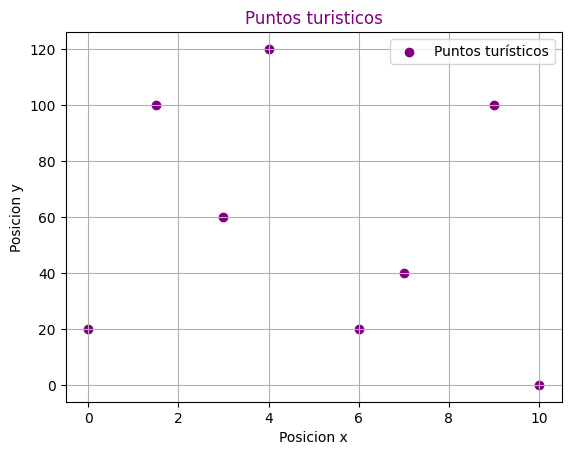

In [63]:
plt.scatter(x_values, y_values, color = 'purple', label = 'Puntos turísticos')
plt.legend()
plt.xlabel('Posicion x')
plt.ylabel('Posicion y')
plt.title('Puntos turisticos', color = 'purple')
plt.grid(True)
plt.show()

## Pregunta 2  

**Como primera aproximacion, vamos a realizar una interpolacion lineal entre cada pareja de puntos contiguos.**

 - **Obten la expresion de l(x)**
 $$
 l(x) =
\begin{cases}
l_0(x) & \text{if } x \in [0, 1.5] \\
l_1(x) & \text{if } x \in [1.5, 3] \\
  \vdots & \vdots \\
l_6(x) & \text{if } x \in [9, 10] \\
\end{cases}
 $$

 - **Representa el polinomio a trozos junto con los puntos turisticos**
 - **Comente con respecto a los cambios de pendiente de la trayectoria**

\newpage

### Solución.

1. **Obtenemos polinomio**


In [64]:
SC = lineal_spline(x_values, y_values)

for i in range(len(x_values)-1):
  rounded_coef = np.polynomial.Polynomial([round(c, 2) for c in SC[i].coef])
  print(f"{rounded_coef}{"; x":>10} in [{x_values[i]}, {x_values[i+1]}]")

20.0 + 53.33·x       ; x in [0, 1.5]
140.0 - 26.67·x       ; x in [1.5, 3]
-120.0 + 60.0·x       ; x in [3, 4]
320.0 - 50.0·x       ; x in [4, 6]
-100.0 + 20.0·x       ; x in [6, 7]
-170.0 + 30.0·x       ; x in [7, 9]
1000.0 - 100.0·x       ; x in [9, 10]


2. **Representación y puntos**

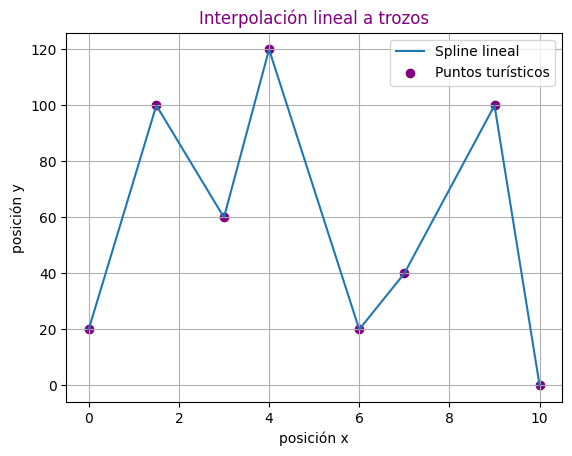

In [65]:
I = np.linspace(min(x_values), max(x_values), 500)
R = eval_spline(SC, x_values, I)
plt.plot(I, R, label="Spline lineal")
plt.xlabel('posición x')
plt.ylabel('posición y')
plt.title('Interpolación lineal a trozos',  color ='purple')
plt.scatter(x_values, y_values, label='Puntos turísticos', color = 'purple')
plt.legend()
plt.grid()
plt.show()

3. **Comentario:**

- Se puede observar en la gráfica de la interpolación lineal una falta de suavidad, ya que presenta  cambios abruptos de pendiente en los puntos donde se conectan dos segmentos. Esto significa que la trayectoria del tranvía cambiaría de dirección de manera brusca en cada parada turística, lo cual podría generar movimientos poco naturales. Por lo que no representa una trayectoria realista.



## Pregunta 3

**Obten el polinomio de interpolacion de Newton n(x) de grado siete que pasa por los ocho paradas, utilizando dos decimales.**

- **Representa el polinomio junto con los puntos de las paradas.**

- **Comente sobre recorrido que tendria que hacer el tranvia de una parada a otra**

### Solución.



1. **Obtenemos polinomio**

In [66]:
# Obtenemos el polinomio interpolador de Newton
polinomio, tabla_diferencias = newton(x_values, y_values)

# Redondeamos los coeficientes a dos decimales
coef_redondeados = np.round(polinomio.coef, 2)

# Creamos un nuevo polinomio con los coeficientes redondeados
polinomio_redondeado = Polynomial(coef_redondeados)
print("Polinomio de interpolación de Newton:")
print(polinomio_redondeado)

Polinomio de interpolación de Newton:
20.0 + 971.05·x - 1339.7·x² + 712.73·x³ - 185.97·x⁴ + 25.38·x⁵ - 1.74·x⁶ +
0.05·x⁷


2. **Representación y puntos**

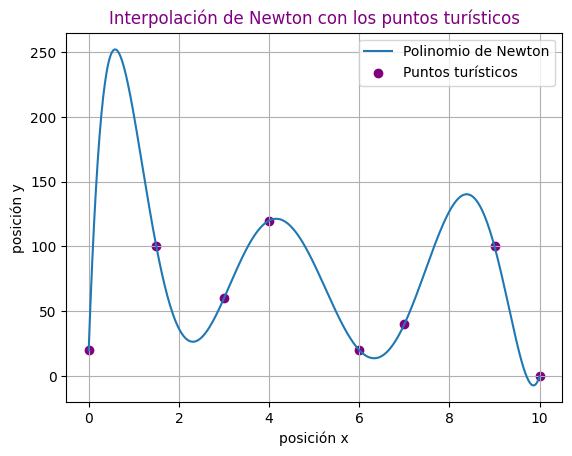

In [67]:
I = np.linspace(min(x_values), max(x_values), 500)
F = polinomio(I)

plt.plot(I, F, label = 'Polinomio de Newton')
plt.scatter(x_values, y_values, color='purple', label="Puntos turísticos")
plt.xlabel('posición x')
plt.ylabel('posición y')
plt.title('Interpolación de Newton con los puntos turísticos', color = 'purple')
plt.legend()
plt.grid()
plt.show()

3. **Comentario:**

- Se puede observar en la gráfica que el polinomio de interpolación de Newton pasa por todas las paradas, garantizando que el tranvía se detenga en cada punto turístico. Sin embargo, debido a la naturaleza del polinomio de grado alto (grado 7), se presenta el fenómeno Runge y el recorrido muestra varias oscilaciones entre las paradas, especialmente cerca de la posición 0 y 1.5, así como entre 6 y 9, lo que sugiere que el tranvía tomaría un camino no muy suave, con cambios bruscos de dirección a lo largo de la ruta. Por lo que  no representa un trayecto eficiente o realista para un tranvía.


## Pregunta 4

- **Obten el polinomio de hermite h(x) de grado 15 que pasa por las ocho paradas considerando como derivada en cada punto el valor 0. Redondea los coeficientes al entero mas proximo (resultara en un polinomio de grado 12).**

- **Representa el polinomio junto con las ubicaciones de las paradas. Comenta sobre la trayectoria que tendrá que realizar el tranvıa.**


### Solución

1. **Obtenemos polinomio**

In [68]:
# Valores de posiciones
DY = [0, 0, 0, 0, 0, 0, 0, 0]

# Obtenemos polinomio de interpolación de Hermite
itr, H, DH = hermite(x_values, y_values, DY)

# Redondeamos los coeficientes al entero más cercano
itr_rounded = Polynomial(np.round(itr.coef))

# Mostramos el polinomio resultante
print("Polinomio de interpolación de Hermite:")
print(itr_rounded)

Polinomio de interpolación de Hermite:
20.0 + 0.0·x + 23329.0·x² - 75580.0·x³ + 107883.0·x⁴ - 89841.0·x⁵ +
48839.0·x⁶ - 18368.0·x⁷ + 4935.0·x⁸ - 962.0·x⁹ + 137.0·x¹⁰ - 14.0·x¹¹ +
1.0·x¹² + -0.0·x¹³ + 0.0·x¹⁴ + -0.0·x¹⁵


2. **Representación y puntos**

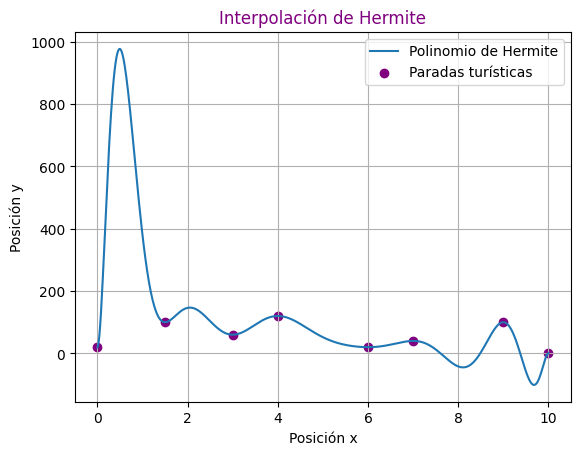

In [69]:
# Crear valores para x para graficar el polinomio
I = np.linspace(min(x_values), max(x_values), 500)
F = itr(I)

# Graficar
plt.plot(I, F, label="Polinomio de Hermite")
plt.scatter(x_values, y_values, color='purple', label="Paradas turísticas")
plt.title("Interpolación de Hermite", color = 'purple')
plt.xlabel("Posición x")
plt.ylabel("Posición y")
plt.legend()
plt.grid(True)
plt.show()

3. **Comentario:**

- Se puede observar en la gráfica que el polinomio de Hermite pasa por todas las paradas. Lo que garantiza que el tranvía se dentendrá en cada punto turístico. Pero el polinomio al ser de grado 12 presenta el Fenómeno Runge donde se puede observar oscilaciones muy grandes, incluso mayores que las del polinomio interpolador de Newton de la pregunta 3. Esto se puede observar especialmente cerca de los puntos 0, 1.5 y 10. Lo que sugiere cambios abruptos en la dirección y velocidad del tranvía. Estos cambios son poco realistas para el diseño de un tranvía.



## Pregunta 5
Utilice Splines naturales cúbicos $s(x)$ que pasan por las ocho paradas, es decir obten la
expresion de $s_i(x) \quad\forall i = 0, 1, . . . 6$, donde
$$
s(x) =
\begin{cases}
s_0(x) & \text{if } x \in [0, 1.5] \\
s_1(x) & \text{if } x \in [1.5, 3] \\
  \vdots & \vdots \\
s_6(x) & \text{if } x \in [9, 10] \\
\end{cases}
$$

**Utilice dos decimales.**
- **Representa el polinomio junto con las paradas.**

- **Comente sobre la trayectoria.**

### Solución

1. **Obtenemos polinomio**

In [70]:
SC = natural_cubic_spline(x_values, y_values)

for i in range(len(x_values)-1):
  rounded_coef = np.polynomial.Polynomial([round(c, 3) for c in SC[i].coef])
  print(f"{rounded_coef}\t   ; x in [{x_values[i]}, {x_values[i+1]}]")

20.0 + 84.428·x + -0.0·x² - 13.82·x³	   ; x in [0, 1.5]
-139.85 + 404.128·x - 213.133·x² + 33.543·x³	   ; x in [1.5, 3]
2379.067 - 2114.789·x + 626.506·x² - 59.75·x³	   ; x in [3, 4]
-3072.668 + 1974.012·x - 395.695·x² + 25.433·x³	   ; x in [4, 6]
5570.966 - 2347.805·x + 324.608·x² - 14.583·x³	   ; x in [6, 7]
5683.741 - 2396.137·x + 331.513·x² - 14.912·x³	   ; x in [7, 9]
-22469.072 + 6988.134·x - 711.184·x² + 23.706·x³	   ; x in [9, 10]


2. **Representación y puntos**

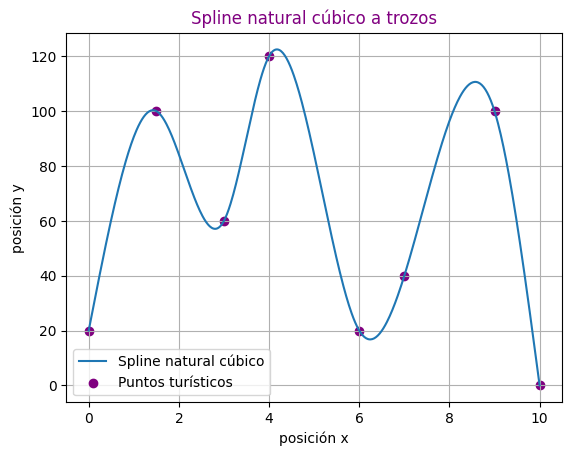

In [71]:
I = np.linspace(min(x_values), max(x_values), 500)
R = eval_spline(SC, x_values, I)
plt.plot(I, R, label="Spline natural cúbico")
plt.xlabel('posición x')
plt.ylabel('posición y')
plt.title('Spline natural cúbico a trozos',  color ='purple')
plt.scatter(x_values, y_values, label='Puntos turísticos', color = 'purple')
plt.legend()
plt.grid()
plt.show()

3. **Comentario:**

- Se puede observar en la gráfica que el Spline cúbico natural representa la trayectoria mas efciente y realista. Puesto que no aparece el fenómeno Runge y la trayectoria del tranvía presenta una curva suave entre cada par de puntos turísticos, lo que implica que la trayectoria del tranvía será fluida, sin cambios bruscos en la dirección ni en la pendiente.

## Pregunta 6
**Representa en una sola gráfica los polinomios de interpolación obtenidos y comente**

### Solución

1. **Representación de las interpolaciones en una sola gráfica**

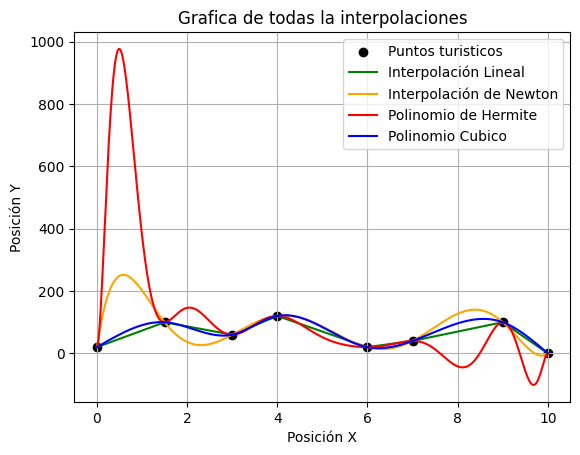

In [72]:
I = np.linspace(min(x_values), max(x_values), 500)
sp_lineal = lineal_spline(x_values, y_values)
pol_newton, _ = newton(x_values, y_values)
itr, _, _ = hermite(x_values, y_values, DY)
sp_cubic = natural_cubic_spline(x_values, y_values)

plt.scatter(x_values,y_values, label='Puntos turisticos', color = 'black')
plt.plot(I, eval_spline(sp_lineal,x_values,I), label = 'Interpolación Lineal', color = 'green')
plt.plot(I, pol_newton(I), label = 'Interpolación de Newton', color='orange')
plt.plot(I, itr(I), label = 'Polinomio de Hermite', color='red')
plt.plot(I, eval_spline(sp_cubic,x_values,I), label = 'Polinomio Cúbico', color = 'blue')

plt.title('Grafica de todas la interpolaciones')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
plt.grid()
plt.legend()
plt.show()

\newpage

2. **Comentario**

- **Interpolación Lineal**: Observamos una gráfica que se pierde. Pero si observamos su gráfica solitaria, vemos los cambios bruscos que tiene cada punto de interpolación (donde la derivada no existe).

- **Interpolación de Newton y Hermite**: Ambas interpolaciones presentan el **fenómeno de Runge**, la oscilación más llamativa en ambos polinomios se presenta al inicio de la trayectoria.

- **Spline Cúbico Natural**: Es mucho más suave si lo comparamos con la interpolación lineal. Aunque su gráfica tiene oscilaciones, no presenta el **fenómeno de Runge**, puesto que no tiene oscilaciones exageradas en comparación con los polinomios de Newton y Hermite.

- **Conclusión**: El Spline Cúbico Natural es la mejor opción porque proporciona una trayectoria fluida y realista, sin oscilaciones ni cambios abruptos, lo que mejora la eficiencia del recorrido del tranvía.